In [1]:
import statsmodels
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import operator

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
import yahoo_fin.stock_info as si
import FundamentalAnalysis as fa
from tqdm import tqdm
import os
import sys
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
def custom_resampler(array_like):
    return np.mean(array_like)

In [3]:
price = si.get_data('AAPL' , start_date = '01/01/1990' , end_date = '01/01/2021', interval='1mo')['close'].resample('Q').apply(custom_resampler)#['close']
#price.index = pd.DatetimeIndex([str(index)[:7] for index in price_per_mo.index])
price.index = pd.DatetimeIndex(price.index)
price.index.set_names(['Date'], inplace=True)
price.head()

Date
1990-03-31    0.322172
1990-06-30    0.373140
1990-09-30    0.321429
1990-12-31    0.328869
1991-03-31    0.537947
Freq: Q-DEC, Name: close, dtype: float64

In [4]:
price_train = price[:120]
price_test = price[120:]

## Analysis


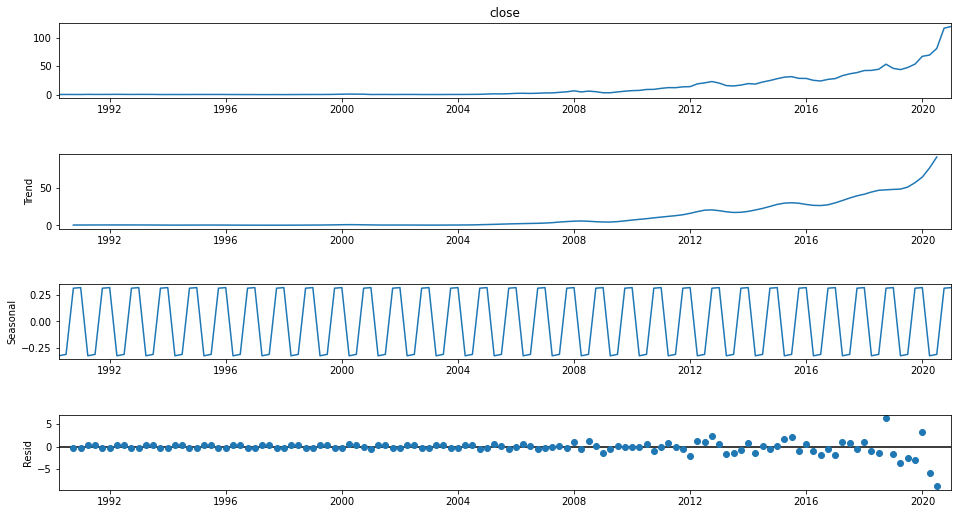

In [5]:
res = sm.tsa.seasonal_decompose(price.dropna())
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

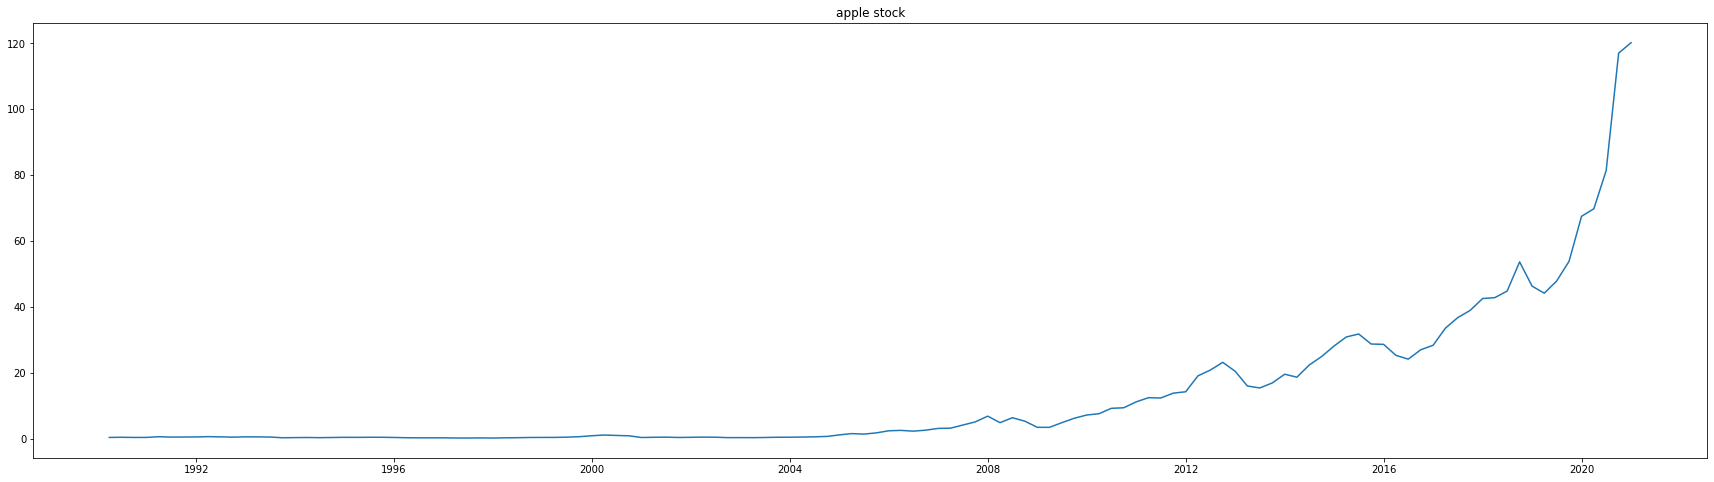

In [6]:
ts_title = "apple stock"
plt.figure(figsize=(30,8))
plt.plot(price)
plt.title(ts_title)
plt.show()

## Parametrs setting


In [7]:
d = 0
ts = price_train

# function "adfuller()" returns a tuple containing these values. The most interesting for us is the "p_value"
test_statistic, p_value, usedlag, nobs, critical_values, icbest = adfuller(ts, regression='c')
print("d = {}. Stationarity test p_value: {}".format(d, p_value))

d = 0. Stationarity test p_value: 0.9989931028219693


In [8]:
d = 1
ts = price_train.diff()

test_statistic, p_value, usedlag, nobs, critical_values, icbest = adfuller(ts.dropna(), regression='c')
print("d = {}. Stationarity test p_value: {}".format(d, p_value))

d = 1. Stationarity test p_value: 0.9986779453414302


In [9]:
d = 2
ts = price_train.diff().diff()

test_statistic, p_value, usedlag, nobs, critical_values, icbest = adfuller(ts.dropna(), regression='c')
print("d = {}. Stationarity test p_value: {}".format(d, p_value))

d = 2. Stationarity test p_value: 1.6197427880580068e-09


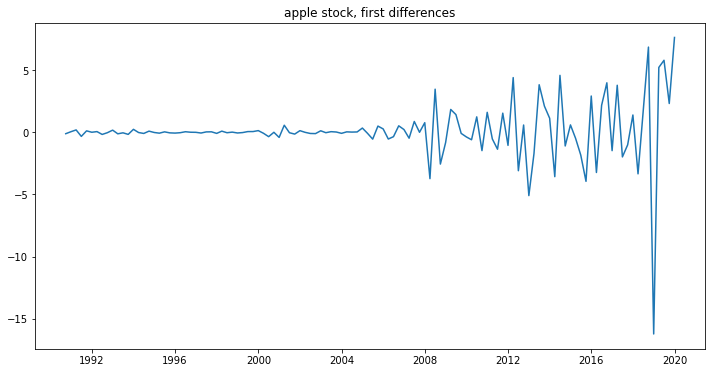

In [10]:
plt.figure(figsize=(12,6))
plt.plot(price_train.diff().diff())
plt.title(ts_title + ", first differences")
plt.show()

In [11]:
from scipy import stats
from scipy.special import boxcox, inv_boxcox

In [12]:
apple_ = pd.DataFrame(boxcox(price_train, 0.2))

In [13]:
d = 0
ts = apple_

# function "adfuller()" returns a tuple containing these values. The most interesting for us is the "p_value"
test_statistic, p_value, usedlag, nobs, critical_values, icbest = adfuller(ts, regression='c')
print("d = {}. Stationarity test p_value: {}".format(d, p_value))

d = 0. Stationarity test p_value: 0.995230063193457


In [14]:
d = 1
ts = apple_.diff()

test_statistic, p_value, usedlag, nobs, critical_values, icbest = adfuller(ts.dropna(), regression='c')
print("d = {}. Stationarity test p_value: {}".format(d, p_value))

d = 1. Stationarity test p_value: 2.994965211418228e-15


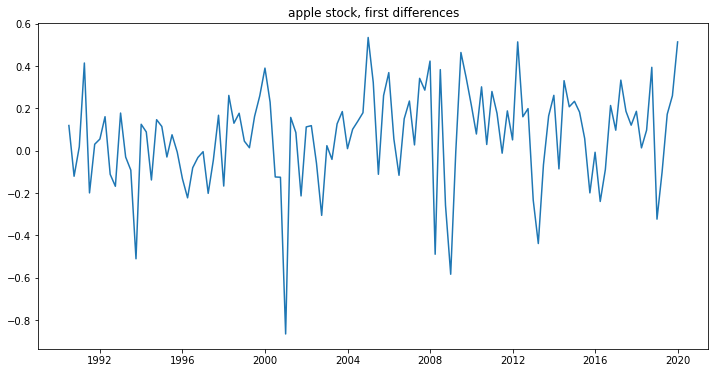

In [15]:
plt.figure(figsize=(12,6))
plt.plot(apple_.diff())
plt.title(ts_title + ", first differences")
plt.show()

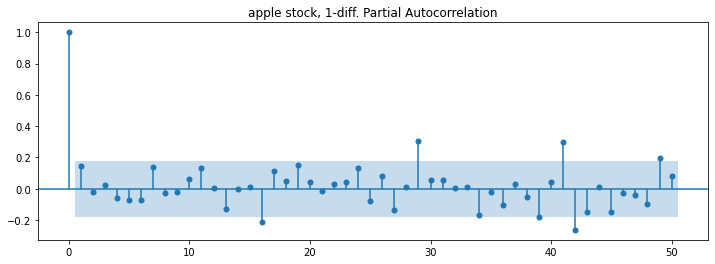

In [16]:
plot_pacf(ts.dropna(), title=ts_title + ", {}-diff. Partial Autocorrelation".format(d), lags=50).set_size_inches(12, 4)
plt.show()

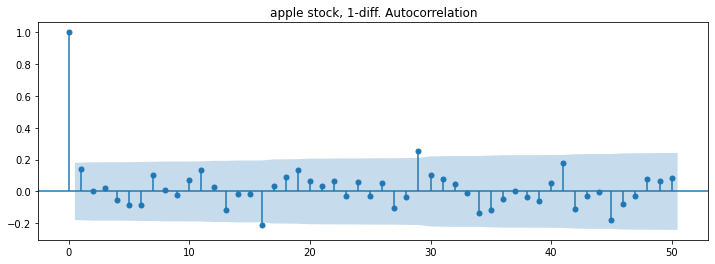

In [17]:
plot_acf(ts.dropna(), title=ts_title + ", {}-diff. Autocorrelation".format(d), lags=50).set_size_inches(12, 4)
plt.show()

## Обучение

#### SARIMA модель
По графикам PACF и ACF строим сетку возможных оптимальных параметров модели и выбираем лучшие:

In [18]:
params_list = [[(p, 1, q), (P, D, Q, 4)] 
               for D in range(2) 
               for P in range(12) 
               for Q in range(12) 
               for p in range(1, 4) 
               for q in range(1, 4)]
min_aic = 10000
max_llf = -10000
for i in tqdm(range(len(params_list))):
    srm = sm.tsa.statespace.SARIMAX(apple_, 
                              order=params_list[i][0], 
                              seasonal_order=params_list[i][1], 
                              enforce_stationarity=False, 
                              enforce_invertibility=False).fit()
    if max_llf < srm.llf:
        max_llf = srm.llf
        best_srm_aic = srm
        
best_srm_aic.summary()      

100%|█████████████████████████████████████████████████████████████████████████| 2592/2592 [1:58:37<00:00,  2.75s/it]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                                      SARIMAX Results                                                       
============================================================================================================================
Dep. Variable:                                                                close   No. Observations:                  120
Model:             SARIMAX(3, 1, 2)x(11, 0, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 4)   Log Likelihood                  16.419
Date:                                                              Wed, 24 Feb 2021   AIC                             23.162
Time:                                                                      00:22:59   BIC                             86.908
Sample:                                                                  03-31-1990   HQIC                            48.540
                                                                       - 12-31-2019                                         
Covariance Type:                                                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1443      0.254      0.568      0.570      -0.354       0.642
ar.L2         -0.6796      0.272     -2.496      0.013      -1.213      -0.146
ar.L3          0.2175      0.182      1.193      0.233      -0.140       0.575
ma.L1          0.1512      2.816      0.054      0.957      -5.369       5.671
ma.L2          1.0007     38.480      0.026      0.979     -74.419      76.420
ar.S.L4        0.4371      0.327      1.335      0.182      -0.205       1.079
ar.S.L8        0.1296      0.352      0.368      0.713      -0.561       0.820
ar.S.L12       0.0149      0.408      0.037      0.971      -0.784       0.814
ar.S.L16      -0.2833      0.265     -1.068      0.285      -0.803       0.237
ar.S.L20      -0.0428      0.257     -0.166      0.868      -0.547       0.461
ar.S.L24       0.1104      0.299      0.369      0.712      -0.477       0.697
ar.S.L28      -0.0438      0.250     -0.175      0.861      -0.534       0.447
ar.S.L32       0.0938      0.178      0.527      0.598      -0.255       0.443
ar.S.L36      -0.0204      0.200     -0.102      0.919      -0.412       0.372
ar.S.L40      -0.0576      0.211     -0.273      0.785      -0.471       0.356
ar.S.L44       0.0965      0.234      0.413      0.679      -0.361       0.554
ma.S.L4       -0.6952     67.528     -0.010      0.992    -133.048     131.657
ma.S.L8        0.1166      6.741      0.017      0.986     -13.095      13.328
ma.S.L12      -0.0872     15.760     -0.006      0.996     -30.975      30.801
ma.S.L16       0.4362     35.514      0.012      0.990     -69.171      70.043
ma.S.L20       0.4520      9.334      0.048      0.961     -17.843      18.747
ma.S.L24       0.2067     16.262      0.013      0.990     -31.667      32.080
ma.S.L28      -0.1057     14.704     -0.007      0.994     -28.924      28.713
ma.S.L32      -0.3605     14.342     -0.025      0.980     -28.469      27.748
ma.S.L36       0.1944     56.001      0.003      0.997    -109.566     109.955
ma.S.L40       0.7197     42.848      0.017      0.987     -83.260      84.700
ma.S.L44      -0.1917     15.489     -0.012      0.990     -30.549      30.166
sigma2         0.0181      1.585      0.011      0.991      -3.088       3.124
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 8.87
Prob(Q):                              0.74   Prob(JB):                         0.01
Heteroskedasticity (H):               1.33   Skew:                            -0.78
Prob(H) (two-sided):                  0.49

Предсказание на один шаг:

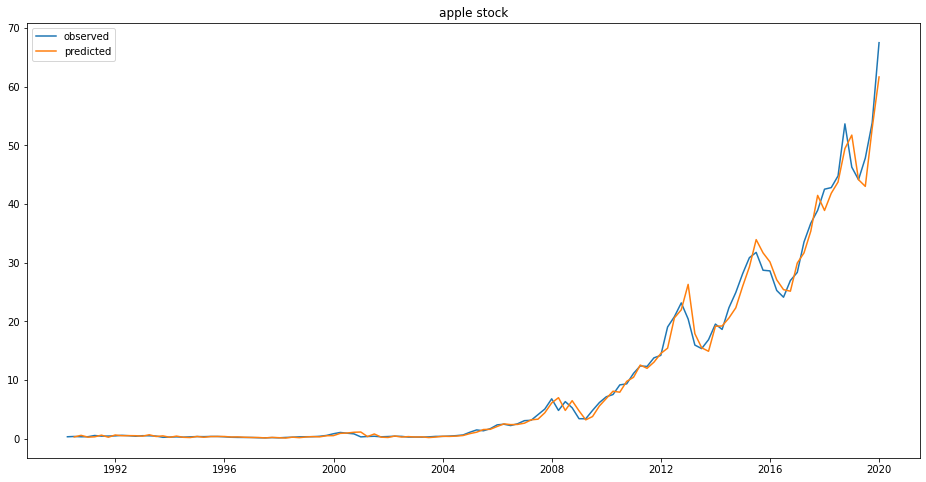

In [19]:
plt.figure(figsize=(16,8))
plt.plot(price_train, color='tab:blue', label='observed')
plt.plot(inv_boxcox(best_srm_aic.predict(start=1), 0.2), color='tab:orange', label='predicted')
# best_srmx_aic
# inv_boxcox(apple_['Close'], 0.4)
plt.legend()
plt.title(ts_title)
plt.show()

Прогноз на год вперёд:

In [101]:
prediction = pd.DataFrame(inv_boxcox(best_srm_aic.predict(price_test.index[0], price_test.index[-1]), 0.2))

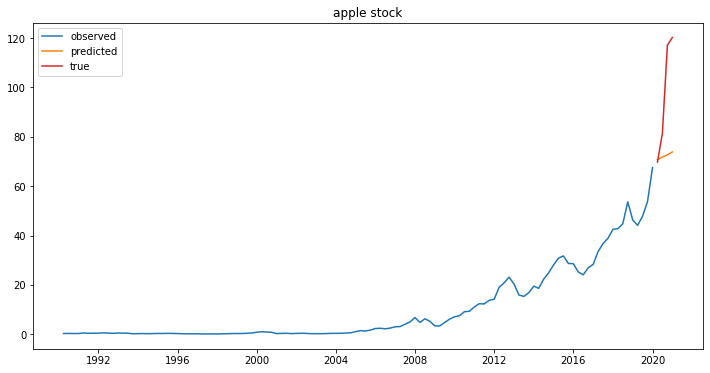

In [102]:
plt.figure(figsize=(12,6))
plt.plot(price_train, color='tab:blue', label='observed')
plt.plot(prediction, color='tab:orange', label='predicted')
plt.plot(price_test, color='tab:red', label='true')
plt.legend()
plt.title(ts_title)
plt.show()

Функция вычисляющая среднее значениеи границы доверительного интервала модели:

In [97]:
def confidence_interval(model, dates, exog_check=False, exog=None, drop=False, drop_columns=None):
    if exog_check:
        if drop:
            prediction_obj = model.get_prediction(start=dates[0], end=dates[-1], exog=fin_rat_test.drop(drop_columns, axis=1), dynamic=0)
        else:
            prediction_obj = model.get_prediction(start=dates[0], end=dates[-1], exog=fin_rat_test, dynamic=0)
    else:
        prediction_obj = model.get_prediction(start=dates[0], end=dates[-1], dynamic=0)
        
    prediction = pd.DataFrame({'mean': inv_boxcox(prediction_obj.predicted_mean, 0.2), 'var': prediction_obj.var_pred_mean}, index=dates)

    # Calculate 95% confidence interval
    prediction['lower'] = prediction['mean'] - 1.96 * np.sqrt(prediction['var'])
    prediction['upper'] = prediction['mean'] + 1.96 * np.sqrt(prediction['var'])
    
    return prediction
    

In [98]:
prediction = confidence_interval(best_srm_aic, price_test.index)

Доверительный интеварл для SARIMA модели:

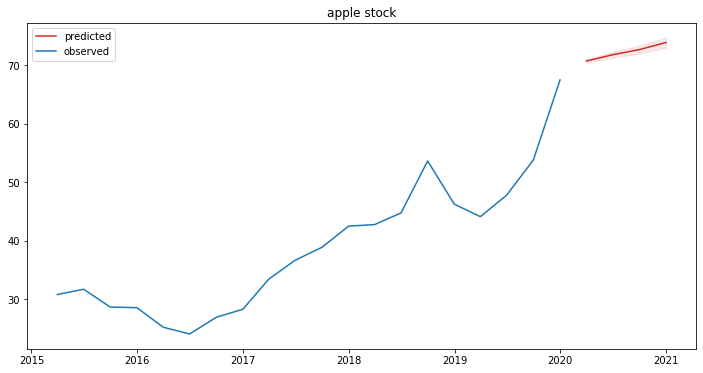

In [99]:
plt.figure(figsize=(12, 6))
plt.fill_between(prediction.index, prediction['lower'], prediction['upper'], alpha=0.1, color='tab:red')
plt.plot(prediction['mean'], color='tab:red', label='predicted')
plt.plot(price_train[100:], color='tab:blue', label='observed')
plt.legend()
plt.title(ts_title)
plt.show()

#### SARIMAX модель

Подготовка датасета признаков:

In [32]:
ticker = "AAPL"
api_key = "e157981136e740dfb515341cbc81540d"
fin_ratios_q = fa.financial_ratios(ticker, api_key, period="quarter")
fin_ratios_q = fin_ratios_q.loc[['currentRatio', 'debtRatio', 'dividendPayoutRatio', 'dividendYield', 'netProfitMargin', 
                              'operatingProfitMargin', 'payoutRatio', 'pretaxProfitMargin', 'priceBookValueRatio', 
                              'priceEarningsRatio', 'priceEarningsToGrowthRatio', 'priceToBookRatio', 'priceToSalesRatio', 
                              'quickRatio', 'returnOnAssets', 'totalDebtToCapitalization']].T[:124]
fin_ratios_q.sort_index(inplace=True)
fin_ratios_q.drop(['totalDebtToCapitalization'], axis=1, inplace=True)
fin_ratios_q.fillna(method='ffill', inplace=True)
#financial_ratios_quarterly.index = pd.DatetimeIndex(financial_ratios_quarterly.index)

fin_ratios_q.index = pd.DatetimeIndex(start=fin_ratios_q.index[0], freq ='Q', periods=len(fin_ratios_q))
fin_ratios_q.index.set_names(['Date'], inplace=True)

fin_ratios_q

,currentRatio,debtRatio,dividendPayoutRatio,dividendYield,netProfitMargin,operatingProfitMargin,payoutRatio,pretaxProfitMargin,priceBookValueRatio,priceEarningsRatio,priceEarningsToGrowthRatio,priceToBookRatio,priceToSalesRatio,quickRatio,returnOnAssets
Date,,,,,,,,,,,,,,,
1990-03-31,2.932817,0.441282,0.098485,0.002544,0.098068,0.147845,0.098485,0.160475,3.294850,38.714489,48.922068,3.294850,3.796666,2.138243,0.047550
1990-06-30,2.636979,0.478547,0.116667,0.002514,0.087912,0.133333,0.116667,0.143590,3.695941,46.414856,57.497831,3.695941,4.080427,1.972943,0.041522
1990-09-30,2.339825,0.513777,0.132653,0.003665,0.072378,0.104136,0.132653,0.118907,2.451505,36.197217,44.068415,2.451505,2.619887,1.712756,0.032930
1990-12-31,2.373134,0.510611,0.092715,0.002761,0.090095,0.136038,0.092715,0.144988,3.282158,33.582346,39.416656,3.282158,3.025617,1.712687,0.047830
1991-03-31,2.824297,0.469901,0.106870,0.001686,0.081977,0.117021,0.106870,0.132666,4.578675,63.402414,77.076782,4.578675,5.197570,1.839357,0.038282
1991-06-30,2.197358,0.517800,-0.264151,0.002815,-0.034663,-0.058208,-0.264151,-0.056246,2.984750,-93.822512,-111.889994,2.984750,3.252186,1.287490,-0.015340
1991-09-30,2.353328,0.494276,0.185185,0.002525,0.053749,0.080292,0.185185,0.086928,3.362337,73.348765,88.516505,3.362337,3.942435,1.479047,0.023183
1991-12-31,2.416994,0.486782,0.084337,0.002084,0.089104,0.141170,0.084337,0.143854,3.493422,40.468984,49.197165,3.493422,3.605932,1.542880,0.044326
1992-03-31,2.603517,0.470439,0.111111,0.001983,0.078671,0.122378,0.111111,0.127040,3.625386,56.045782,69.189372,3.625386,4.409196,1.765787,0.034255


In [33]:
fin_rat_train = fin_ratios_q[:120]
fin_rat_test = fin_ratios_q[120:]

Также подбираем параметры модели на основе результатов предыдущих результатов оптимизации модели SARIMA с использованием признаков финансовых отчетов (то есть SARIMAX):

In [47]:
params_list = [[(3, 1, 2), (11, 0, Q, 4)]  
               for Q in range(12) ]
min_aic = 10000
max_llf = -10000
for i in tqdm(range(len(params_list))):
    _srmx = sm.tsa.statespace.SARIMAX(apple_, 
                              order=params_list[i][0], 
                              seasonal_order=params_list[i][1], 
                              exog=fin_rat_train,      
                              enforce_stationarity=False, 
                              enforce_invertibility=False).fit()
    if max_llf < _srmx.llf:
        max_llf = _srmx.llf
        _best_srmx_llf = _srmx
_best_srmx_llf.summary()

100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [00:57<00:00,  4.75s/it]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                      close   No. Observations:                  120
Model:             SARIMAX(3, 1, 2)x(11, 0, [1, 2, 3], 4)   Log Likelihood                  10.917
Date:                                    Wed, 24 Feb 2021   AIC                             48.167
Time:                                            06:17:08   BIC                            127.850
Sample:                                        03-31-1990   HQIC                            79.889
                                             - 12-31-2019                                         
Covariance Type:                                      opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
currentRatio                   0.0398      0.698      0.057      0.955      -1.328       1.408
debtRatio                     -0.2366      0.393     -0.602      0.547      -1.008       0.534
dividendPayoutRatio          198.4043    251.350      0.789      0.430    -294.232     691.041
dividendYield                -18.8916    100.696     -0.188      0.851    -216.253     178.470
netProfitMargin                0.3238      3.512      0.092      0.927      -6.560       7.208
operatingProfitMargin          0.1718      3.438      0.050      0.960      -6.567       6.911
payoutRatio                 -198.5048    251.352     -0.790      0.430    -691.145     294.135
pretaxProfitMargin             1.1193      4.233      0.264      0.791      -7.178       9.416
priceBookValueRatio            0.0685      0.028      2.431      0.015       0.013       0.124
priceEarningsRatio             0.0022      0.011      0.197      0.844      -0.019       0.024
priceEarningsToGrowthRatio    -0.0013      0.007     -0.192      0.848      -0.015       0.012
priceToBookRatio               0.0685      0.028      2.431      0.015       0.013       0.124
priceToSalesRatio              0.0088      0.035      0.254      0.799      -0.059       0.076
quickRatio                    -0.0030      0.682     -0.004      0.996      -1.339       1.333
returnOnAssets                -3.1588      4.775     -0.662      0.508     -12.518       6.201
ar.L1                         -0.4197      0.398     -1.053      0.292      -1.201       0.361
ar.L2                          1.4760      0.473      3.119      0.002       0.548       2.404
ar.L3                         -0.2105      0.419     -0.503      0.615      -1.031       0.610
ma.L1                          0.6498      0.867      0.749      0.454      -1.050       2.350
ma.L2                         -1.5041      0.800     -1.881      0.060      -3.071       0.063
ar.S.L4                        0.1967      0.468      0.420      0.674      -0.720       1.114
ar.S.L8                        0.3436      0.455      0.755      0.450      -0.549       1.236
ar.S.L12                      -0.0451      0.450     -0.100      0.920      -0.928       0.837
ar.S.L16                       0.0079      0.277      0.028      0.977      -0.535       0.551
ar.S.L20                       0.1151      0.200      0.575      0.565      -0.277       0.507
ar.S.L24                       0.1002      0.254      0.394      0.693      -0.398       0.598
ar.S.L28                      -0.0964      0.279     -0.345      0.730      -0.644       0.451
ar.S.L32                       0.1858      0.208      0.894      0.372      -0.222       0.593
ar.S.L36                       0.0612      0.185      0.331      0.741      -0.301       0.423
ar.S.L40             

По корреляционной матрице попробуем отобрать наиболее эффективные и не скоррелированные между собой признаки:

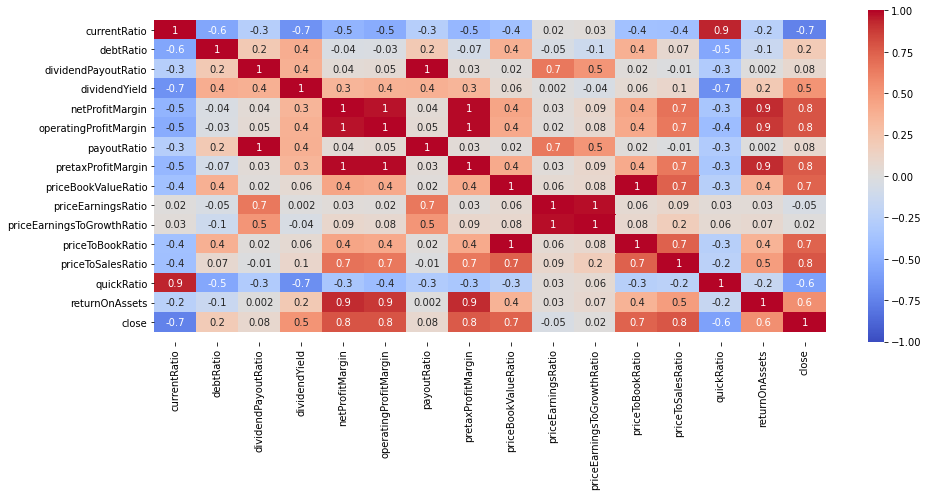

In [46]:
plt.figure(figsize=(14,7), tight_layout=True)
sns.heatmap(fin_ratios_q.join(apple_).corr(), center = 0, annot = True, fmt='.1g', vmin=-1, vmax=1, cmap= 'coolwarm')

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

Подбор параметров по сетке с отобранными признаками:

In [44]:
params_list = [[(3, 1, 2), (11, 0, Q, 4)]  
               for Q in range(12) ]
min_aic = 10000
max_llf = -10000
for i in tqdm(range(len(params_list))):
    srmx = sm.tsa.statespace.SARIMAX(apple_, 
                              order=params_list[i][0], 
                              seasonal_order=params_list[i][1], 
                              exog=fin_rat_train.drop(['operatingProfitMargin', 'pretaxProfitMargin', 'dividendPayoutRatio',
                                                       'priceBookValueRatio', 'priceEarningsToGrowthRatio'], axis=1),      
                              enforce_stationarity=False, 
                              enforce_invertibility=False).fit()
    if max_llf < srmx.llf:
        max_llf = srmx.llf
        best_srmx_llf = srmx
best_srmx_llf.summary()

100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [01:03<00:00,  5.31s/it]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                                      SARIMAX Results                                                       
============================================================================================================================
Dep. Variable:                                                                close   No. Observations:                  120
Model:             SARIMAX(3, 1, 2)x(11, 0, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 4)   Log Likelihood                  15.864
Date:                                                              Wed, 24 Feb 2021   AIC                             44.272
Time:                                                                      00:58:31   BIC                            130.786
Sample:                                                                  03-31-1990   HQIC                            78.714
                                                                       - 12-31-2019                                         
Covariance Type:                                                                opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
currentRatio           0.0345      0.723      0.048      0.962      -1.383       1.452
debtRatio             -0.1883      0.484     -0.389      0.697      -1.137       0.760
dividendYield         15.2228     48.206      0.316      0.752     -79.259     109.704
netProfitMargin        2.1277      1.491      1.427      0.154      -0.795       5.050
payoutRatio           -0.1281      0.201     -0.637      0.524      -0.522       0.266
priceEarningsRatio -6.183e-05      0.000     -0.333      0.739      -0.000       0.000
priceToBookRatio       0.1915      0.038      4.980      0.000       0.116       0.267
priceToSalesRatio     -0.0102      0.016     -0.641      0.522      -0.042       0.021
quickRatio            -0.0343      0.700     -0.049      0.961      -1.406       1.337
returnOnAssets        -4.2370      4.099     -1.034      0.301     -12.271       3.797
ar.L1                 -0.1844      0.503     -0.367      0.714      -1.170       0.801
ar.L2                  1.3103      0.440      2.978      0.003       0.448       2.173
ar.L3                 -0.1994      0.453     -0.441      0.660      -1.086       0.688
ma.L1                  0.7432      1.028      0.723      0.470      -1.271       2.758
ma.L2                 -1.6213      1.203     -1.348      0.178      -3.978       0.736
ar.S.L4                0.0391      0.556      0.070      0.944      -1.051       1.129
ar.S.L8               -0.1492      0.401     -0.372      0.710      -0.936       0.637
ar.S.L12               0.1612      0.472      0.341      0.733      -0.765       1.087
ar.S.L16              -0.0209      0.468     -0.045      0.964      -0.937       0.896
ar.S.L20               0.1711      0.316      0.542      0.588      -0.448       0.790
ar.S.L24              -0.0052      0.443     -0.012      0.991      -0.873       0.863
ar.S.L28              -0.0911      0.392     -0.232      0.816      -0.860       0.677
ar.S.L32               0.2147      0.288      0.746      0.456      -0.349       0.779
ar.S.L36               0.0621      0.382      0.162      0.871      -0.688       0.812
ar.S.L40              -0.1855      0.359     -0.517      0.605      -0.889       0.518
ar.S.L44              -0.1478      0.264     -0.561      0.575      -0.665       0.369
ma.S.L4                0.1080      0.716      0.151      0.880      -1.295       1.511
ma.S.L8               -0.1396      0.471     -0.296      0.767      -1.062       0.783
ma.S.L12               0.1510      0.647      0.233      0.815      -1.116       1.418
ma.S.L16               0.1003      0.540   

Теперь попробуем провести подбор признаков для модели SARIMAX по сетке на основе графиков PACF и ACF, с отобранными по корреляционной матрице признаками

In [45]:
params_list = [[(p, 1, q), (P, D, Q, 4)] 
               for D in range(2) 
               for P in range(12) 
               for Q in range(12) 
               for p in range(1, 4) 
               for q in range(1, 4)]
min_aic = 10000
max_llf = -10000
for i in tqdm(range(len(params_list))):
    srmx_ = sm.tsa.statespace.SARIMAX(apple_, 
                              order=params_list[i][0], 
                              seasonal_order=params_list[i][1], 
                              exog=fin_rat_train.drop(['operatingProfitMargin', 'pretaxProfitMargin', 'dividendPayoutRatio',
                                                       'priceBookValueRatio', 'priceEarningsToGrowthRatio'], axis=1), 
                              enforce_stationarity=False, 
                              enforce_invertibility=False).fit()
    if max_llf < srmx_.llf:
        max_llf = srmx_.llf
        best_srmx_llf_ = srmx_
        
best_srmx_llf_.summary()    

100%|█████████████████████████████████████████████████████████████████████████| 2592/2592 [4:34:41<00:00,  6.36s/it]


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                  120
Model:               SARIMAX(3, 1, 3)   Log Likelihood                  62.359
Date:                Wed, 24 Feb 2021   AIC                            -90.718
Time:                        05:39:42   BIC                            -44.054
Sample:                    03-31-1990   HQIC                           -71.778
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
currentRatio        4.129e-05      0.345      0.000      1.000      -0.675       0.675
debtRatio             -0.2274      0.177     -1.284      0.199      -0.574       0.120
dividendYield         15.2227     31.608      0.482      0.630     -46.728      77.174
netProfitMargin        2.0821      0.452      4.609      0.000       1.197       2.967
payoutRatio           -0.0447      0.052     -0.851      0.395      -0.148       0.058
priceEarningsRatio -3.905e-05      0.000     -0.176      0.860      -0.000       0.000
priceToBookRatio       0.1901      0.022      8.574      0.000       0.147       0.234
priceToSalesRatio     -0.0152      0.008     -1.946      0.052      -0.030       0.000
quickRatio            -0.0840      0.333     -0.252      0.801      -0.737       0.569
returnOnAssets        -4.2673      1.513     -2.821      0.005      -7.232      -1.303
ar.L1                 -0.3476      0.253     -1.374      0.170      -0.844       0.148
ar.L2                  0.3043      0.197      1.548      0.122      -0.081       0.689
ar.L3                  0.7272      0.199      3.646      0.000       0.336       1.118
ma.L1                  0.5785      0.262      2.210      0.027       0.065       1.092
ma.L2                 -0.1450      0.273     -0.532      0.595      -0.679       0.389
ma.L3                 -0.6995      0.211     -3.313      0.001      -1.113      -0.286
sigma2                 0.0203      0.004      5.764      0.000       0.013       0.027
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                15.24
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.86   Skew:                            -0.71
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Построим прогнозы моделей на год вперёд:

In [104]:
prediction1 = pd.DataFrame(inv_boxcox(_best_srmx_llf.predict(price_test.index[0], price_test.index[-1], exog=fin_rat_test), 0.2))
prediction2 = pd.DataFrame(inv_boxcox(best_srmx_llf.predict(price_test.index[0], price_test.index[-1], exog=fin_rat_test.drop(['operatingProfitMargin', 'pretaxProfitMargin', 'dividendPayoutRatio',
                                                       'priceBookValueRatio', 'priceEarningsToGrowthRatio'], axis=1)), 0.2))
prediction3 = pd.DataFrame(inv_boxcox(best_srmx_llf_.predict(price_test.index[0], price_test.index[-1], exog=fin_rat_test.drop(['operatingProfitMargin', 'pretaxProfitMargin', 'dividendPayoutRatio',
                                                       'priceBookValueRatio', 'priceEarningsToGrowthRatio'], axis=1)), 0.2))

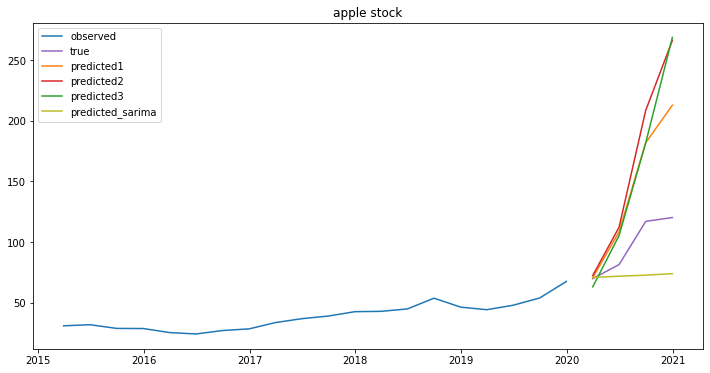

In [108]:
plt.figure(figsize=(12,6))
plt.plot(price_train[100:], color='tab:blue', label='observed')
plt.plot(price_test, color='tab:purple', label='true')
plt.plot(prediction1, color='tab:orange', label='predicted1')
plt.plot(prediction2, color='tab:red', label='predicted2')
plt.plot(prediction3, color='tab:green', label='predicted3')
plt.plot(prediction, color='tab:olive', label='predicted_sarima')
plt.legend()
plt.title(ts_title)
plt.show()

Теперь построим доверительные интервалы для получившихся моделей:

In [88]:
drop_cols = ['operatingProfitMargin', 'pretaxProfitMargin', 'dividendPayoutRatio',
                                                       'priceBookValueRatio', 'priceEarningsToGrowthRatio']

In [89]:
prediction1 = confidence_interval(_best_srmx_llf, price_test.index, True, fin_rat_test)
prediction2 = confidence_interval(best_srmx_llf, price_test.index, True, fin_rat_test, True, drop_cols)
prediction3 = confidence_interval(best_srmx_llf_, price_test.index, True, fin_rat_test, True, drop_cols)

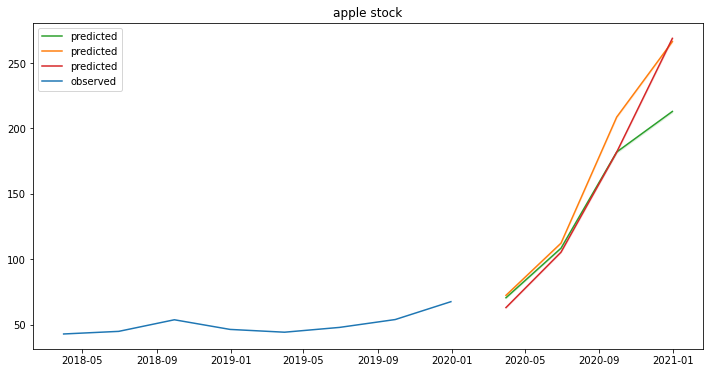

In [96]:
plt.figure(figsize=(12, 6))

plt.fill_between(prediction1.index, prediction1['lower'], prediction1['upper'], alpha=0.1, color='tab:green')
plt.plot(prediction1['mean'], color='tab:green', label='predicted')

plt.fill_between(prediction2.index, prediction2['lower'], prediction2['upper'], alpha=0.1, color='tab:orange')
plt.plot(prediction2['mean'], color='tab:orange', label='predicted')

plt.fill_between(prediction3.index, prediction3['lower'], prediction3['upper'], alpha=0.1, color='tab:red')
plt.plot(prediction3['mean'], color='tab:red', label='predicted')


plt.plot(price_train[112:], color='tab:blue', label='observed')
plt.legend()
plt.title(ts_title)
plt.show()

# Выводы:

- Последний оптимизированный SARIMAX даёт наименьшую ошибку по сравнению с SARIMA.
- Отбор признаков по корреляционной матрице дал хороший прирост функции максимального правдоподобия и AIC.
- В SARIMAX признаки финансовых показателей заменили сезонной компоненту модели SARIMA, соответственно стоит сделать вывод, что для достижения наибольшей точности необходимо проводить обучение по сетке занаво.
- Доверительный интервал достаточно узкий на всех моделях, что говорит о малом разбросе.
- SARIMAX переоценивает целевую переменную, в то время как SARIMA наоборот недооценивает. Учитывая хорошую объясняющую функцию финансовых показателей стоит сделать вывод, что отклонение целевой переменной от прогноза SARIMAX имеет внешнюю слабопрогнозируемую природу, например новости отрасли. 
- Рассмотрев график прогнозов всех моделей и реальных показателей, можно предположить о наличии отложенного спроса во втором и третьем квартале, который привел к отложенному росту показателя. Также можно заметить замедляющийся положительный тренд цены акций, что также может говорить о проявлениях последствий коронавирусного кризиса.